In [5]:
#importing libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix , classification_report

In [6]:
!nvidia-smi

Tue Oct 25 13:47:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs mmio_stale_data retbleed
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power

In [8]:
#setting all the constants
group_size = 32
image_size = 256
channel = 3
epoch = 50

In [9]:
#importing all the images into tensorflow dataset object
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory="/content/drive/MyDrive/Colab Notebooks/PlantVillage",batch_size=group_size,image_size=(image_size,image_size),seed=123,shuffle=True)

Found 2152 files belonging to 3 classes.


In [10]:
#printing all the classname from the given dataset
class_name = image_dataset.class_names
print(class_name)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [11]:
# printing the shape and label list from first 10 batches of image_dataset
for image_batch, labels_batch in image_dataset.take(10):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]
(32, 256, 256, 3)
[1 0 0 1 1 0 1 0 0 1 0 2 0 1 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0]
(32, 256, 256, 3)
[1 1 1 2 1 0 1 0 1 1 1 1 0 0 1 0 1 0 0 2 2 1 0 0 1 0 1 1 2 0 1 1]
(32, 256, 256, 3)
[1 0 1 1 1 1 1 0 0 0 0 1 2 1 0 2 0 0 1 0 0 1 1 1 1 0 2 1 0 1 2 1]
(32, 256, 256, 3)
[1 1 1 0 1 0 1 0 2 1 1 1 0 0 2 2 0 0 0 0 1 0 2 0 1 0 1 0 1 0 1 0]
(32, 256, 256, 3)
[1 0 2 0 1 1 0 0 0 2 1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 2 0 1 1 1 1 1]
(32, 256, 256, 3)
[1 0 1 0 0 1 1 0 1 2 1 1 0 0 2 2 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1]
(32, 256, 256, 3)
[1 1 0 0 0 0 0 1 1 0 1 1 2 1 1 2 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 2]
(32, 256, 256, 3)
[0 0 1 2 0 0 2 0 0 1 1 1 1 1 1 1 1 1 0 1 2 0 0 1 0 1 2 0 1 1 1 1]
(32, 256, 256, 3)
[0 2 0 1 0 1 1 0 1 1 2 0 0 0 1 0 2 0 0 0 2 0 0 0 1 1 0 1 1 1 0 0]


In [12]:
plt.rcParams['figure.figsize'] = (16,10)

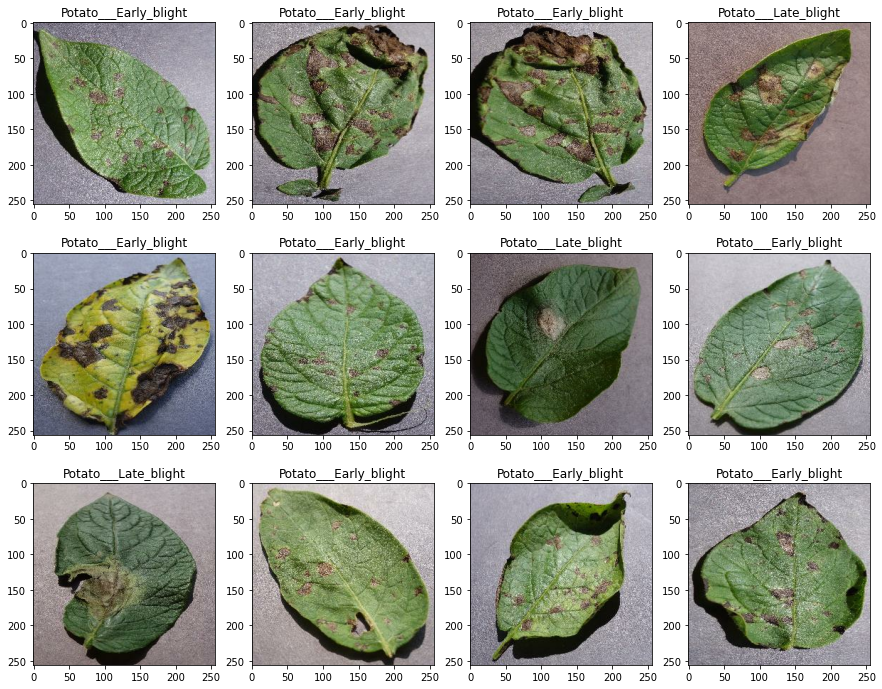

In [13]:
# Visualizing some images from the first batch
plt.rcParams['figure.figsize'] = (15,12)
for image_batch, labels_batch in image_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[labels_batch[i]])

In [14]:
# Splitting the dataset --> 80% for training, 10% for testing and 10% for validation.
# Generating a function that splits the dataset for training and testing
def partition_of_dataset(dataset,train_split,test_split,val_split):
    if(train_split+test_split+val_split) == 1:
        dataset_size = len(dataset)
        dataset = dataset.shuffle(buffer_size=10000,seed=12)
        
        train_size = int(train_split * dataset_size)
        val_size = int(val_split * dataset_size)
        
        train_dataset = dataset.take(train_size)
        val_dataset = dataset.skip(train_size).take(val_size)
        test_dataset = dataset.skip(train_size).skip(val_size)
        
        return train_dataset, test_dataset, val_dataset
    else:
        print("Training Testing partition is not done correctly")

In [15]:
train_ds, test_ds, val_ds = partition_of_dataset(image_dataset,train_split=0.8,test_split=0.1,val_split=0.1)

In [16]:
# printing the batch size of training , testing and validation
print("Training size is {}".format(len(train_ds)))
print("Testing size is {}".format(len(test_ds)))
print("Validation size is {}".format(len(val_ds)))

Training size is 54
Testing size is 8
Validation size is 6


In [17]:
# Counting the number of images from each class
total_count = {"early_blight": 0,"late_blight": 0,"healthy": 0}
for image_batch, labels_batch in image_dataset.take(len(image_dataset)):
    for i in labels_batch.numpy():
        if i == 0:
            total_count['early_blight'] += 1
        elif i == 1:
            total_count['late_blight'] += 1
        else:
            total_count['healthy'] += 1

# Counting the number of images of each class from training dataset
training_count = {"early_blight": 0,"late_blight": 0,"healthy": 0}
for image_batch, labels_batch in image_dataset.take(len(train_ds)):
    for i in labels_batch.numpy():
        if i == 0:
            training_count['early_blight'] += 1
        elif i == 1:
            training_count['late_blight'] += 1
        else:
            training_count['healthy'] += 1

# Counting the number of images of each class from testing dataset
testing_count = {"early_blight": 0,"late_blight": 0,"healthy": 0}
for image_batch, labels_batch in image_dataset.take(len(test_ds)):
    for i in labels_batch.numpy():
        if i == 0:
            testing_count['early_blight'] += 1
        elif i == 1:
            testing_count['late_blight'] += 1
        else:
            testing_count['healthy'] += 1

# Counting the number of images of each class from validation dataset
val_count = {"early_blight": 0,"late_blight": 0,"healthy": 0}
for image_batch, labels_batch in image_dataset.take(len(val_ds)):
    for i in labels_batch.numpy():
        if i == 0:
            val_count['early_blight'] += 1
        elif i == 1:
            val_count['late_blight'] += 1
        else:
            val_count['healthy'] += 1

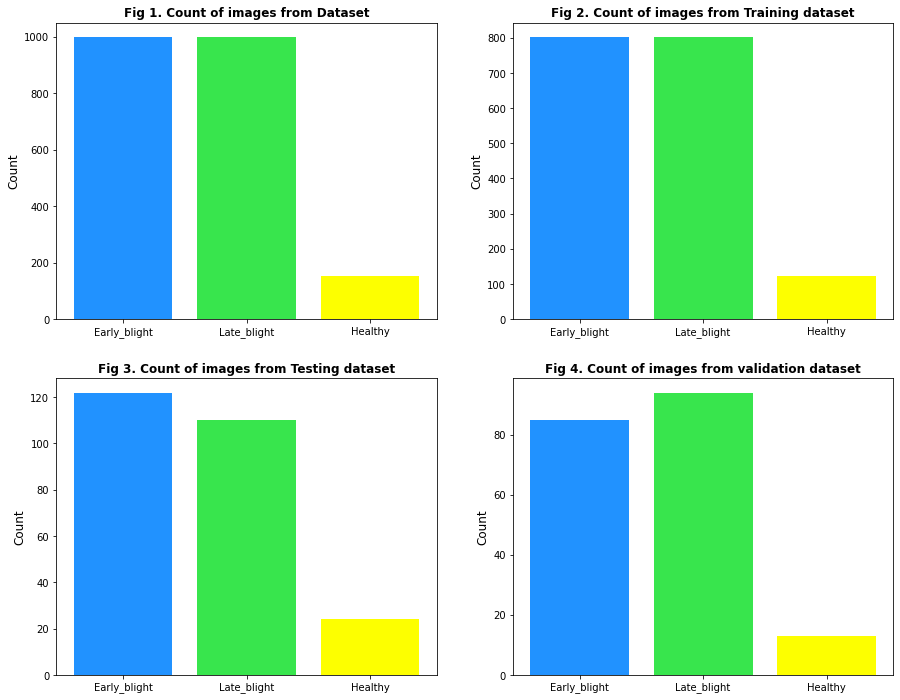

In [18]:
# Plotting graph
color = ['#2192FF','#38E54D','#FDFF00']
plt.subplot(2,2,1)
plt.bar(x = ["Early_blight","Late_blight","Healthy"],height=[total_count['early_blight'],total_count['late_blight'],total_count['healthy']],color=color)
plt.ylabel("Count",size=12)
# plt.grid(axis="y",color = 'green', linestyle = '--')
plt.title("Fig 1. Count of images from Dataset",fontweight="bold")

plt.subplot(2,2,2)
plt.bar(x = ["Early_blight","Late_blight","Healthy"],height=[training_count['early_blight'],training_count['late_blight'],training_count['healthy']],color=color)
plt.ylabel("Count",size=12)
plt.title("Fig 2. Count of images from Training dataset",fontweight="bold")

plt.subplot(2,2,3)
plt.bar(x = ["Early_blight","Late_blight","Healthy"],height=[testing_count['early_blight'],testing_count['late_blight'],testing_count['healthy']],color=color)
plt.ylabel("Count",size=12)
plt.title("Fig 3. Count of images from Testing dataset",fontweight="bold")

plt.subplot(2,2,4)
plt.bar(x = ["Early_blight","Late_blight","Healthy"],height=[val_count['early_blight'],val_count['late_blight'],val_count['healthy']],color=color)
plt.ylabel("Count",size=12)
plt.title("Fig 4. Count of images from validation dataset",fontweight="bold")


plt.show();

In [19]:
print("Total count is ",total_count)
print("Training count is ",training_count)
print("Testing count is ",testing_count)
print("Validation count is ",val_count)

Total count is  {'early_blight': 1000, 'late_blight': 1000, 'healthy': 152}
Training count is  {'early_blight': 803, 'late_blight': 803, 'healthy': 122}
Testing count is  {'early_blight': 122, 'late_blight': 110, 'healthy': 24}
Validation count is  {'early_blight': 85, 'late_blight': 94, 'healthy': 13}


In [20]:
resizing_and_rescaling = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(image_size, image_size),
  layers.experimental.preprocessing.Rescaling(1./255),])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),])

In [22]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (group_size, image_size, image_size, channel)
n_classes = 3

model = models.Sequential([
    resizing_and_rescaling,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [24]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [25]:
history = model.fit(train_ds,batch_size=group_size,validation_data=val_ds,verbose=1,epochs=epoch,)

Epoch 1/50
54/54 [==============================] - 33s 362ms/step - loss: 0.9194 - accuracy: 0.4812 - val_loss: 0.8536 - val_accuracy: 0.4896
Epoch 2/50
54/54 [==============================] - 23s 365ms/step - loss: 0.8363 - accuracy: 0.5839 - val_loss: 0.7755 - val_accuracy: 0.6667
Epoch 3/50
54/54 [==============================] - 24s 371ms/step - loss: 0.5535 - accuracy: 0.8015 - val_loss: 0.7157 - val_accuracy: 0.7656
Epoch 4/50
54/54 [==============================] - 23s 364ms/step - loss: 0.4804 - accuracy: 0.8228 - val_loss: 0.3301 - val_accuracy: 0.9062
Epoch 5/50
54/54 [==============================] - 23s 366ms/step - loss: 0.3525 - accuracy: 0.8568 - val_loss: 0.2837 - val_accuracy: 0.8750
Epoch 6/50
54/54 [==============================] - 23s 366ms/step - loss: 0.2811 - accuracy: 0.8920 - val_loss: 0.2146 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 23s 366ms/step - loss: 0.2389 - accuracy: 0.9120 - val_loss: 0.2131 - val_accuracy: 0.9323

In [30]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 37ms/step - loss: 0.0644 - accuracy: 0.9766


In [31]:
print("Accuracy of our model is {} for our test dataset.".format(scores[1]*100))

Accuracy of our model is 97.65625 for our test dataset.


In [29]:
actual_label = []
predicted_label = []
for images_batch, labels_batch in test_ds.take(len(test_ds)):
  batch_prediction = model.predict(images_batch)
  for i in labels_batch:
    actual_label.append(class_name[labels_batch[i]])
    predicted_label.append(class_name[np.argmax(batch_prediction[i])])

1/1 [==============================] - 0s 29ms/step


In [32]:
# print(actual_label)
# print(predicted_label)

In [33]:
cm = confusion_matrix(actual_label,predicted_label)

Text(113.09375, 0.5, 'Predicted Values')

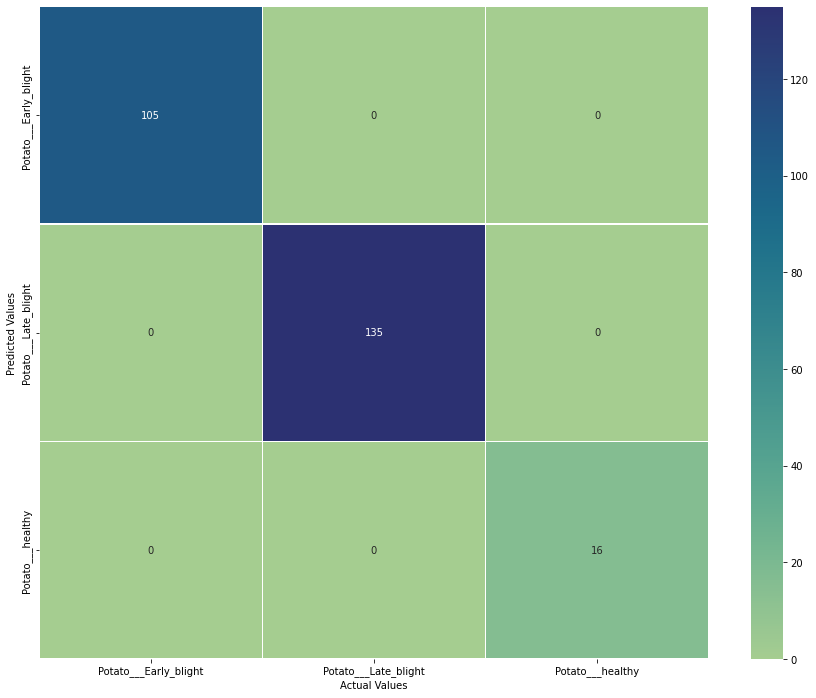

In [34]:
sns.heatmap(cm,annot=True,cmap="crest",fmt='g',linewidth=.5,xticklabels=class_name,yticklabels=class_name)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

In [35]:
print(classification_report(actual_label, predicted_label))

                       precision    recall  f1-score   support

Potato___Early_blight       1.00      1.00      1.00       105
 Potato___Late_blight       1.00      1.00      1.00       135
     Potato___healthy       1.00      1.00      1.00        16

             accuracy                           1.00       256
            macro avg       1.00      1.00      1.00       256
         weighted avg       1.00      1.00      1.00       256



In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


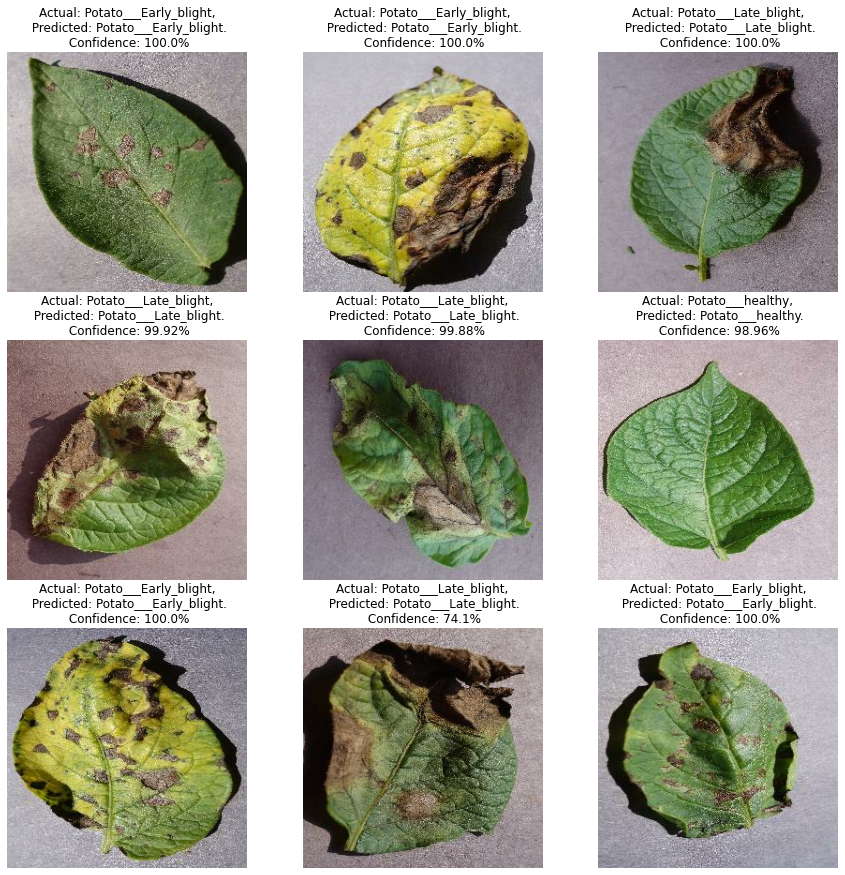

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

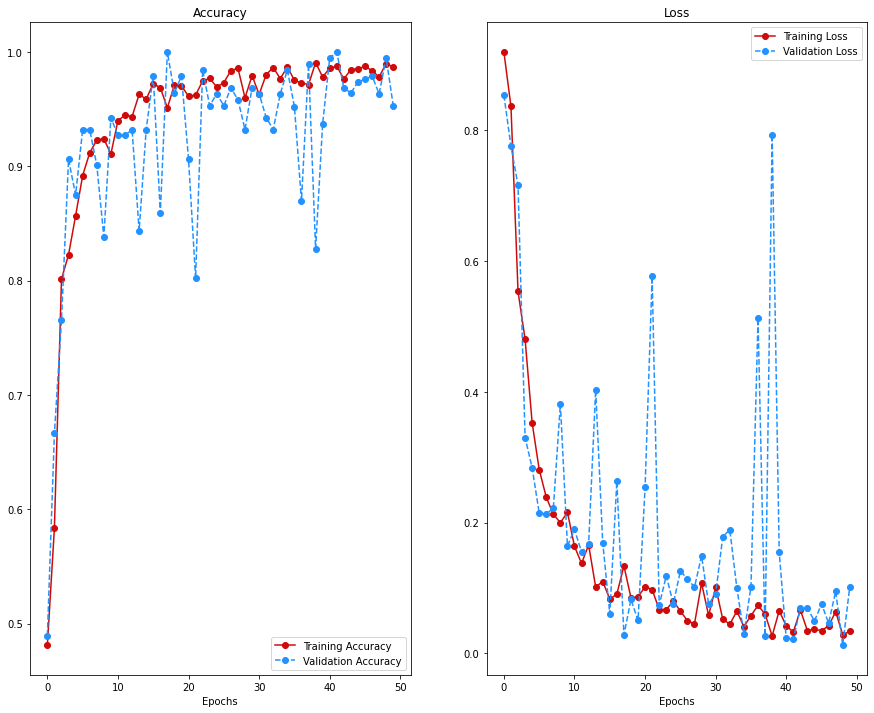

In [38]:
# Plotting accuracy 
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs_range = range(epoch)

plt.subplot(1,2,1)
plt.plot(epochs_range, accuracy,'-o', label='Training Accuracy',color="#CF0A0A")
plt.plot(epochs_range, val_accuracy,'o--', label='Validation Accuracy',color="#2192FF")
plt.xlabel("Epochs")
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss,'-o', label='Training Loss',color="#CF0A0A")
plt.plot(epochs_range, val_loss,'o--', label='Validation Loss',color="#2192FF")
plt.xlabel("Epochs")
plt.legend()
plt.title('Loss')
plt.show();